# Error estimation
**Note: first run of this cell takes a while**

In [15]:

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
import util, config, plots
import ipynbname
import pandas as pd
import numpy as np
import json
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation of standard deviation w.r.t modification rate

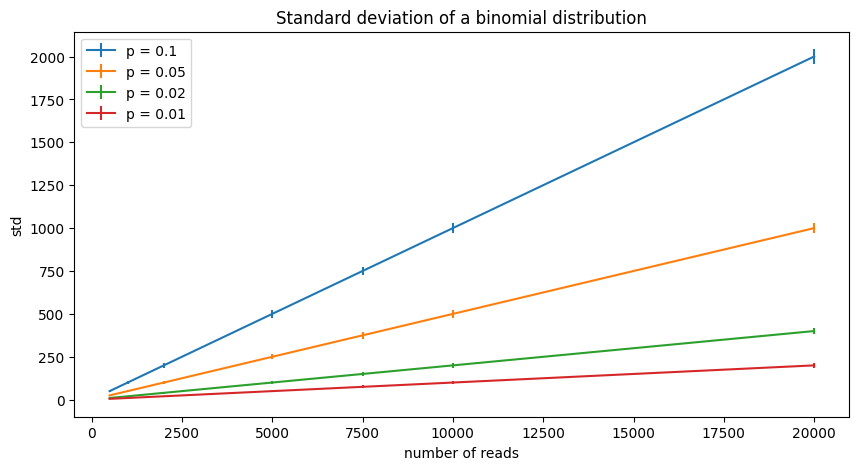

In [2]:
# plot the mean of a binomial distribution with n=[500, 1000, 2000, 5000, 7500, 10000, 20000] and p=[0.01, 0.02, 0.05, 0.1]
# use the standard deviation as a measure of error
import numpy as np
import matplotlib.pyplot as plt

n = np.array([500, 1000, 2000, 5000, 7500, 10000, 20000])
p = np.array([0.01, 0.02, 0.05, 0.1])
p = p[::-1]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for p_ in p:
    ax.errorbar(n, [p_]*n, label='p = {}'.format(p_), yerr=np.sqrt(n*p_*(1-p_)))
ax.set(xlabel='number of reads', ylabel='std', title='Standard deviation of a binomial distribution')
ax.legend()
plt.show()
    

## Barcode replicates simulation
### Experimental: what distributino to expect?

## Introduction

The bootstrap always fits a binomial distribution, independent of the underlying distribution. 

In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Full dataset stats
N, D = 10000, 1000
data = np.concatenate(( (np.random.rand(N, D//2) < 0.02).astype(int), (np.random.rand(N, D//2) < 0.03).astype(int) ), axis=1)
muts_count = np.sum(data, axis=0)


# Stats on one column of data
data_col = data[:, np.random.randint(0, D-1)]

bootstrap_data = np.random.choice(data_col, size=(N, D), replace=True)

muts_count_bs = np.sum(bootstrap_data, axis=0)

# Make a Plotly subplot with the histogram of muts_count on the first row and the bootstrapping on the second row
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)

fig.add_trace(go.Histogram(x=muts_count, histnorm='probability density', name='Original dataset' ), col=1, row=1)

fig.add_trace(go.Histogram(x=muts_count_bs, histnorm='probability density', name='bootstrap data'), col=1, row=2)

# Draw a binomial distribution on top of the histogram, with n=1000 and p estimated from the data
from scipy.stats import binom
x = np.arange(min(muts_count_bs), max(muts_count_bs)).astype(int)
fig.add_trace(go.Scatter(x=x, y=binom.pmf(x, len(data_col), np.count_nonzero(data_col)/len(data_col)), mode='lines', name='binomial'), col=1, row=2)

## Load real dataset

In [4]:
data = pd.read_orc('../../bv/01_1_s22_reads_3043.orc')

def process_data(data):
    data = data.to_numpy(dtype=np.byte).astype(float)
    data[data == 0] = 0
    data[data < 0] = 128
    data[data < 64] = 0
    data[data > 0] = 1
    return data

data = process_data(pd.read_orc('../../bv/01_1_S22_reads_3081.orc'))
sample = data[np.random.randint(0, data.shape[0], size=N)]
observed_freq = sample.sum(axis=0)/N

# Bootstrap vs binomial distribution


## Bootstrap
### Define bootstrap function

In [5]:
def bootstrap(sample, n=1000):
    """
    Bootstrap the sample
    """
    n, r = sample.shape
    res = np.zeros((n, r))
    for i in range(n):
        res[i] = sample[np.random.randint(0, n, n)].sum(axis=0)
    return res

def predict_confidence_interval_bootstrap(sample, bootstrap_iterations=1000):
    bs = bootstrap(sample, n=bootstrap_iterations)
    lower_bound, upper_bound = np.percentile(bs, [2.5, 97.5], axis=0)/size_sample
    return lower_bound, upper_bound
    

## Binomial distribution

### Define function

In [6]:
def predict_confidence_interval_binomial_distribution(observed_freq, size_sample):
    """
    Predict the confidence interval using the binomial distribution
    """
    lower_bound = observed_freq - 1.96*np.sqrt(observed_freq*(1-observed_freq)/size_sample)
    upper_bound = observed_freq + 1.96*np.sqrt(observed_freq*(1-observed_freq)/size_sample)
    return lower_bound, upper_bound
    



##  Wilson score 
### Define function

In [7]:
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = np.sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

## Clopper-Pearson 
### Define function

In [8]:
def clopper_pearson(*args):
    return sm.stats.proportion_confint(*args, method='beta', alpha=0.05)

## Agresti-Coull
### Define function

In [9]:
def agresti_coull(*args):
    return sm.stats.proportion_confint(*args, method='agresti_coull', alpha=0.05)

## Poisson

In [10]:
import scipy

def predict_confidence_interval_poisson(observed_freq, size_sample, alpha=0.05):
    cov = size_sample
    mut = observed_freq*size_sample
    return 0.5*scipy.stats.chi2.ppf(alpha/2, df=2*mut)/cov, 0.5*scipy.stats.chi2.ppf(1-alpha/2, df=2*(mut+1))/cov


# Let's compare the different methods

In [11]:

n_trials_per_dataset = 100
bootstrap_iterations = 10000
methods = ['bootstrap', 'binomial', 'wilson', 'clopper_pearson', 'agresti_coull', 'poisson']
size_samples = [500, 1000, 2000, 3000, 5000, 10000]

failures_df = pd.DataFrame()
size_df = pd.DataFrame()

for size_sample in size_samples:
    failures = {m:[] for m in methods}
    size_ci = {m:[] for m in methods}

    for f in os.listdir('../../bv'):
        
        # read dataset
        data = process_data(pd.read_orc('../../bv/' + f))
        true_mutation_rate = data.sum(axis=0)/data.shape[0]

        fail = {m:[] for m in methods}
        size = {m:[] for m in methods}
        
        for _ in range(n_trials_per_dataset):
            
            # generate a new sample
            sample = data[np.random.randint(0, data.shape[0], size=size_sample)]
            observed_freq = sample.sum(axis=0)/size_sample
            
            # count failures bootstrap
            lb_bs, ub_bs = predict_confidence_interval_bootstrap(sample, bootstrap_iterations=bootstrap_iterations)
            fail['bootstrap'].append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])
            size['bootstrap'].append(np.mean(ub_bs - lb_bs))
            
            # count failures binomial
            lb_bin, ub_bin = predict_confidence_interval_binomial_distribution(observed_freq, size_sample)
            fail['binomial'].append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])
            size['binomial'].append(np.mean(ub_bin - lb_bin))
            
            # count Wilson failures
            lb_wilson, ub_wilson = wilson(observed_freq, size_sample)
            fail['wilson'].append(100*np.logical_or(ub_wilson < true_mutation_rate, lb_wilson > true_mutation_rate).sum()/data.shape[1])
            size['wilson'].append(np.mean(ub_wilson - lb_wilson))
            
            # count Clopper-Pearson failures
            lb_cp, ub_cp = clopper_pearson(observed_freq*size_sample, size_sample)
            fail['clopper_pearson'].append(100*np.logical_or(ub_cp < true_mutation_rate, lb_cp > true_mutation_rate).sum()/data.shape[1])
            size['clopper_pearson'].append(np.mean(ub_cp - lb_cp))
            
            # count Agresti-Coull failures
            lb_ac, ub_ac = agresti_coull(observed_freq*size_sample, size_sample)
            fail['agresti_coull'].append(100*np.logical_or(ub_ac < true_mutation_rate, lb_ac > true_mutation_rate).sum()/data.shape[1])
            size['agresti_coull'].append(np.mean(ub_ac - lb_ac))
            
            # count Poisson failures
            lb_poisson, ub_poisson = predict_confidence_interval_poisson(observed_freq, size_sample)
            fail['poisson'].append(100*np.logical_or(ub_poisson < true_mutation_rate, lb_poisson > true_mutation_rate).sum()/data.shape[1])
            size['poisson'].append(np.mean(ub_poisson - lb_poisson))

        for m in methods:
            failures[m].append(fail[m])
            size_ci[m].append(size[m])
        #    print(f'{n_dataset}: {m}: {np.mean(failures[m][-1])}% failure rate')
        #print('----------------------------------------------------------')
    
    df = pd.DataFrame(
        {
            'Bootstrap': np.array(failures['bootstrap']).flatten(), 
            'Binomial': np.array(failures['binomial']).flatten(), 
            'Wilson': np.array(failures['wilson']).flatten(),
            'Clopper-Pearson': np.array(failures['clopper_pearson']).flatten(),
            'Agresti-Coull': np.array(failures['agresti_coull']).flatten(),
            'Poisson': np.array(failures['poisson']).flatten(),
            'size_sample': size_sample,
        })

    failures_df = pd.concat([failures_df, df], axis=0)

    df = pd.DataFrame(
        {
            'Bootstrap': np.array(size_ci['bootstrap']).flatten(), 
            'Binomial': np.array(size_ci['binomial']).flatten(), 
            'Wilson': np.array(size_ci['wilson']).flatten(),
            'Clopper-Pearson': np.array(size_ci['clopper_pearson']).flatten(),
            'Agresti-Coull': np.array(size_ci['agresti_coull']).flatten(),
            'Poisson': np.array(size_ci['poisson']).flatten(),
            'size_sample': size_sample        
        })
    size_df = pd.concat([size_df, df], axis=0)
    
fig = px.box(failures_df, y=[c for c in df.columns if c != 'size_sample'], color='size_sample', title='Failure rate of the confidence interval methods. n_bootstrap = {}, n_iter = {} iterations *{} datasets'.format(bootstrap_iterations, n_trials_per_dataset, len(os.listdir('../../bv'))))
fig.update_yaxes(title_text="Failure rate (%)")
fig.update_xaxes(title_text="Method")

# add a horizontal line at y=5 all the way across the figure legend y=5 
fig.add_shape(type="line", x0=0, y0=5, x1=1, y1=5, line=dict(color="Green", width=2, dash="dash"), xref="paper", yref="y")

# add a horizontal line at y=2.5
fig.add_shape(type="line", x0=0, y0=2.5, x1=1, y1=2.5, line=dict(color="Red", width=2, dash="dash", ), xref="paper", yref="y")

fig.show()
    
fig = px.box(size_df, y=[c for c in df.columns if c != 'size_sample'], color='size_sample', title='Size of the confidence interval methods. n_bootstrap = {}, n_iter = {} iterations *{} datasets'.format(bootstrap_iterations, n_trials_per_dataset, len(os.listdir('../../bv'))))
fig.update_yaxes(title_text="Size of the CI")
fig.update_xaxes(title_text="Method")
fig.show()

# save to file
fig.to_html('failure_rate.html')

## Conclusion

Past 2000 reads, all methods are very similar.

For 2000 reads and below, the most accurate method is the Wilson score interval.

# Are two mutation histograms similar?

In [12]:
import plotly.graph_objects as go
from scipy import stats

n=1000
n1 = 510
n2 = 1000
p1 = 0.012
p2 = 0.01
P1 = np.random.binomial(n1, p1, n)/n1
P2 = np.random.binomial(n2, p2, n)/n2

# Calculate the Fisher's exact test
def fisher_exact_test(n1, p1, n2, p2):
    # Calculate the odds ratio
    oddsratio, pvalue = stats.fisher_exact([[n1*p1, n1*(1-p1)], [n2*p2, n2*(1-p2)]])
    return oddsratio, pvalue

pval = []
for p1, p2 in zip(P1, P2):
    oddsratio, pvalue = fisher_exact_test(n1, p1, n2, p2)
    pval.append(pvalue)

    
# Plot the results
fig = go.Figure()
fig.add_trace(go.Histogram(x=pval, histnorm='probability density'))
fig.update_layout(
    title='Fisher exact test p-values per residue pair',
    xaxis_title='p-value',
    yaxis_title='Probability density',
    bargap=0.2,
    bargroupgap=0.1
)
fig.show()


# Combine the p-values using the Fisher's method
def combine_pvalues(pvalues):
    return -2 * np.sum(np.log(pvalues))

# Calculate the combined p-value
combined_pvalue = combine_pvalues(pval)

# Compute the p-value from the chi-squared distribution
pvalue = 1 - stats.chi2.cdf(combined_pvalue, 2 * len(pval))

# Print the results
print('Combined p-value: {:.2e}'.format(pvalue))

# Run the experiment 1000 times
N = 1000
pvalues = []
for i in range(N):
    # Generate the data
    n1 = 510
    n2 = 1000
    p1 = 0.012
    p2 = 0.01
    P1 = np.random.binomial(n1, p1, n)/n1
    P2 = np.random.binomial(n2, p2, n)/n2
    
    # Calculate the p-values
    pval = []
    for p1, p2 in zip(P1, P2):
        oddsratio, pvalue = fisher_exact_test(n1, p1, n2, p2)
        pval.append(pvalue)
    
    # Combine the p-values
    combined_pvalue = combine_pvalues(pval)
    
    # Compute the p-value from the chi-squared distribution
    pvalue = 1 - stats.chi2.cdf(combined_pvalue, 2 * len(pval))
    
    # Store the p-value
    pvalues.append(pvalue)
    
# Plot the results
fig = go.Figure()
fig.add_trace(go.Histogram(x=pvalues, histnorm='probability density'))
fig.update_layout(
    title='Combined p-values from Fisher exact test',
    xaxis_title='p-value',
    yaxis_title='Probability density',
    bargap=0.2,
    bargroupgap=0.1
)

Combined p-value: 9.95e-01


## Using this theoretical distribution, we can compute the p-value of the difference between two histograms

In [17]:
from study_gen import study
from plots import *

In [25]:

sample = '19_plasmid_S12_L001'
replicates_lists = generate_dataset.generate_barcode_replicates_pairs(study, sample)       
data = study.df[(study.df['sample'] == sample) & (study.df['section'] == 'full')][['sample','construct','section','mut_rates','num_aligned','sequence']]
barcode_bounds = [139,151]

for col in ['mut_rates','sequence']:
    data[col] = data[col].apply(lambda x: np.array(x[:barcode_bounds[0]]).tolist() + np.array(x[barcode_bounds[1]:]).tolist())

data['mut_rates'] = data.apply(lambda x: np.array(x['mut_rates'])[np.logical_or(np.array(x['sequence']) == 'A',np.array(x['sequence']) == 'C')], axis=1)

{'3149-O-flank_1=hp10-DB': ['3150-CC-flank_1=hp10-DB'],
 '3150-CC-flank_1=hp10-DB': ['3149-O-flank_1=hp10-DB'],
 '3042-O-flank_1=hp1-DB': ['3043-CC-flank_1=hp1-DB'],
 '3043-CC-flank_1=hp1-DB': ['3042-O-flank_1=hp1-DB'],
 '3512-O-flank_1=bi2-pp7-DB': ['3513-CC-flank_1=bi2-pp7-DB'],
 '3513-CC-flank_1=bi2-pp7-DB': ['3512-O-flank_1=bi2-pp7-DB'],
 '3175-O-flank_1=hp12-DB': ['3176-CC-flank_1=hp12-DB'],
 '3176-CC-flank_1=hp12-DB': ['3175-O-flank_1=hp12-DB'],
 '3288-O-flank_1=cb7-DB': ['3324-O-flank_1=cb10-DB',
  '3336-O-flank_1=cb11-DB',
  '3348-O-flank_1=cb12-DB'],
 '3324-O-flank_1=cb10-DB': ['3288-O-flank_1=cb7-DB',
  '3336-O-flank_1=cb11-DB',
  '3348-O-flank_1=cb12-DB'],
 '3336-O-flank_1=cb11-DB': ['3288-O-flank_1=cb7-DB',
  '3324-O-flank_1=cb10-DB',
  '3348-O-flank_1=cb12-DB'],
 '3348-O-flank_1=cb12-DB': ['3288-O-flank_1=cb7-DB',
  '3324-O-flank_1=cb10-DB',
  '3336-O-flank_1=cb11-DB'],
 '3080-O-flank_1=hp4-DB': ['3081-CC-flank_1=hp4-DB'],
 '3081-CC-flank_1=hp4-DB': ['3080-O-flank_1=hp4-DB

##

## Experimental: what does a Pearson replicates distribution look like with perfect replication?

In [24]:
for c1, c2 in replicates_lists:
    print(c2)

ValueError: too many values to unpack (expected 2)